In [1]:
import burst_detection as bd
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Kleinberg burst

In [2]:
node=pd.read_csv('./node.csv',names=['user_id','longtitude','latitude','app_name','app_type_name','start_time'],index_col=0)
node=node[['user_id','app_type_name','start_time']]
node=node.sort_values(['user_id','app_type_name','start_time'])
node=node.drop_duplicates()

In [3]:
# choose the top 10% and last 10%
zscore_category=pd.read_csv('./siteexample1/zscore_category.csv',index_col=0)

lowest=zscore_category.sort_values(by=['terminal_price','fees'],ascending=False)[int(len(zscore_category)*0.90):-1]
lower_class=lowest['user_id'].values

highest=zscore_category.sort_values(by=['terminal_price','fees'],ascending=False)[:int(len(zscore_category)*0.10)-1]
upper_class=highest['user_id'].values

In [ ]:
def kleinberg(offsets, s=2, gamma=1):

    if s <= 1:
        raise ValueError("s must be greater than 1!")
    if gamma <= 0:
        raise ValueError("gamma must be positive!")
    if len(offsets) < 1:
        raise ValueError("offsets must be non-empty!")

    offsets = np.array(offsets, dtype=object)

    if offsets.size == 1:
        bursts = np.array([0, offsets[0], offsets[0]], ndmin=2, dtype=object)
        return bursts

    offsets = np.sort(offsets)
    gaps = np.diff(offsets)

    if not np.all(gaps):
        raise ValueError("Input cannot contain events with zero time between!")

    T = np.sum(gaps)
    n = np.size(gaps)
    g_hat = T / n

    k = int(math.ceil(float(1 + math.log(T, s) + math.log(1 / np.amin(gaps), s))))

    gamma_log_n = gamma * math.log(n)

    def tau(i, j):
        if i >= j:
            return 0
        else:
            return (j - i) * gamma_log_n

    alpha_function = np.vectorize(lambda x: s ** x / g_hat)
    alpha = alpha_function(np.arange(k))

    def f(j, x):
        return alpha[j] * math.exp(-alpha[j] * x)

    C = np.repeat(float("inf"), k)
    C[0] = 0

    q = np.empty((k, 0))
    for t in range(n):
        C_prime = np.repeat(float("inf"), k)
        q_prime = np.empty((k, t+1))
        q_prime.fill(np.nan)

        for j in range(k):
            cost_function = np.vectorize(lambda x: C[x] + tau(x, j))
            cost = cost_function(np.arange(0, k))

            el = np.argmin(cost)

            if f(j, gaps[t]) > 0:
                C_prime[j] = cost[el] - math.log(f(j, gaps[t]))

            if t > 0:
                q_prime[j,:t] = q[el,:]

            q_prime[j, t] = j + 1

        C = C_prime
        q = q_prime

    j = np.argmin(C)
    q = q[j,:]

    prev_q = 0

    N = 0
    for t in range(n):
        if q[t] > prev_q:
            N = N + q[t] - prev_q
        prev_q = q[t]

    bursts = np.array([np.repeat(np.nan, N), np.repeat(offsets[0],N),np.repeat(offsets[0], N)], ndmin=2, dtype=object).transpose()

    burst_counter = -1
    prev_q = 0
    stack = np.repeat(np.nan, N)
    stack_counter = -1
    for t in range(n):
        if q[t] > prev_q:
            num_levels_opened = q[t] - prev_q
            for i in range(int(num_levels_opened)):
                burst_counter += 1
                bursts[burst_counter, 0] = prev_q + i
                bursts[burst_counter, 1] = offsets[t]
                stack_counter += 1
                stack[stack_counter] = burst_counter
        elif q[t] < prev_q:
            num_levels_closed = prev_q - q[t]
            for i in range(int(num_levels_closed)):
                bursts[int(stack[int(stack_counter)]), 2] = offsets[int(t)]
                stack_counter -= 1
        prev_q = q[t]

    while stack_counter >= 0:
        bursts[int(stack[stack_counter]), 2] = offsets[n]
        stack_counter -= 1

    return bursts,2

In [20]:
app_type_name=['位置', '其他资讯', '社交沟通', '网页浏览', '视频', '软件工具', '搜索', '旅游',
       '生活服务', '社区论坛', '邮箱', '游戏', '阅读', '音乐', '支付', '电商购物', '房产',
       '招聘']

In [110]:
for i in app_type_name:
    print(i)
    depth_list=[]
    for j in lower_class:
#         print(j)
        example=node[(node['user_id']==j)&(node['app_type_name']==i)]['start_time'].values
        if len(example)!=0:
            s=2; gamma=0.1
            offsets = list(example)
            bursts = kleinberg(offsets, s=s, gamma=gamma)

            if len(bursts)>1:
                burstsdf=pd.DataFrame(bursts[0], columns=['intensity', 'start','end'])
            else:
                burstsdf=pd.DataFrame(bursts, columns=['intensity', 'start','end'])

            depth=burstsdf['intensity'].max()
            # width=len(burstsdf[burstsdf['intensity']==1])
            depth_list.append(depth)
            
    avg=sum(depth_list)/len(depth_list)
    print(avg) 

for i in app_type_name:
    print(i)
    depth_list=[]
    for j in upper_class:
#         print(j)
        example=node[(node['user_id']==j)&(node['app_type_name']==i)]['start_time'].values
        if len(example)!=0:
            s=2; gamma=0.1
            offsets = list(example)
            bursts = kleinberg(offsets, s=s, gamma=gamma)

            if len(bursts)>1:
                burstsdf=pd.DataFrame(bursts[0], columns=['intensity', 'start','end'])
            else:
                burstsdf=pd.DataFrame(bursts, columns=['intensity', 'start','end'])

            depth=burstsdf['intensity'].max()
            # width=len(burstsdf[burstsdf['intensity']==1])
            depth_list.append(depth)
    avg=sum(depth_list)/len(depth_list)
    print(avg) 

位置
14.3087248322
其他资讯
15.1978319783
社交沟通
13.25
网页浏览
13.4391304348
视频
14.4783861671
软件工具
14.6442307692
搜索
13.9713375796
旅游
10.2352941176
生活服务


KeyboardInterrupt: 

# daily routine - attention

In [2]:
node=pd.read_csv('./node.csv',names=['user_id','longtitude','latitude','app_name','app_type_name','start_time'],index_col=0)
node=node[['user_id','app_type_name','start_time']]
node=node.sort_values(['user_id','app_type_name','start_time'])
node=node.drop_duplicates()

In [3]:
# choose the top 10% and last 10%
zscore_category=pd.read_csv('./siteexample1/zscore_category.csv',index_col=0)

lowest=zscore_category.sort_values(by=['terminal_price','fees'],ascending=False)[int(len(zscore_category)*0.90):-1]
lower_class=lowest['user_id'].values

highest=zscore_category.sort_values(by=['terminal_price','fees'],ascending=False)[:int(len(zscore_category)*0.10)-1]
upper_class=highest['user_id'].values

In [4]:
node['date']=node['start_time'].apply(lambda x: int(str(x)[6:8]))
node['hour']=node['start_time'].apply(lambda x: int(str(x)[8:10]))

node=node[['user_id','app_type_name','date','hour']]

In [5]:
low=node.loc[node['user_id'].isin(lower_class)]
# low=node.loc[~node['user_id'].isin(lower_class)] isnotin

low_date_count=low.groupby('user_id')['date'].nunique().reset_index()

low_overall=low.groupby(['user_id'])['hour'].value_counts().reset_index(name='count')

diction=dict(low_date_count[['user_id','date']].values)

low_overall['date']=low_overall['user_id'].apply(lambda x : diction[x]
                                                if x in diction
                                                else np.nan)

low_overall['low_number']=low_overall['count']/low_overall['date']

low_overall=low_overall.groupby('hour')['low_number'].sum().reset_index()
low_overall['low_number']=low_overall['low_number']/len(lower_class)

In [6]:
high=node.loc[node['user_id'].isin(upper_class)]

high_date_count=high.groupby('user_id')['date'].nunique().reset_index()

high_overall=high.groupby(['user_id'])['hour'].value_counts().reset_index(name='count')

diction=dict(high_date_count[['user_id','date']].values)

high_overall['date']=high_overall['user_id'].apply(lambda x : diction[x]
                                                if x in diction
                                                else np.nan)

high_overall['high_number']=high_overall['count']/high_overall['date']

high_overall=high_overall.groupby('hour')['high_number'].sum().reset_index()
high_overall['high_number']=high_overall['high_number']/len(upper_class)

In [7]:
attention=pd.merge(high_overall,low_overall,on='hour')

In [27]:
attention

,hour,high_number,low_number
0,0,3.831992,7.639166
1,1,2.827595,5.252255
2,2,1.715521,4.104894
3,3,1.345515,3.775240
4,4,1.169802,3.622827
5,5,1.153966,4.104872
6,6,2.033587,5.869878
7,7,6.797477,8.820395
8,8,9.801210,10.076371
9,9,9.652897,10.094449


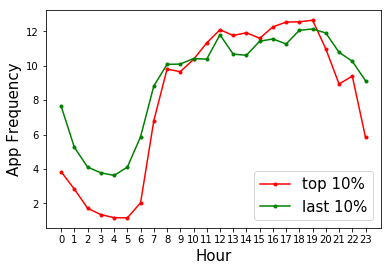

In [8]:
x=range(0,24)
plt.plot(x,attention['high_number'].values,'.-',label='top 10%',color='red')
plt.plot(x,attention['low_number'].values,'.-',label='last 10%',color='green')
plt.legend(fontsize=15)
plt.xticks(x,)
plt.xlabel('Hour',fontsize=15)
plt.ylabel('App Frequency',fontsize=15)
plt.show()

In [9]:
low_category_overall=low.groupby(['user_id','app_type_name'])['hour'].value_counts().reset_index(name='count')

diction=dict(low_date_count[['user_id','date']].values)
low_category_overall['date']=low_category_overall['user_id'].apply(lambda x : diction[x]
                                                if x in diction
                                                else np.nan)

low_category_overall['low_number']=low_category_overall['count']/low_category_overall['date']

low_category_overall=low_category_overall.groupby(['app_type_name','hour'])['low_number'].sum().reset_index()

low_category_overall['low_number']=low_category_overall['low_number']/len(lower_class)

In [10]:
high_category_overall=high.groupby(['user_id','app_type_name'])['hour'].value_counts().reset_index(name='count')

diction=dict(high_date_count[['user_id','date']].values)
high_category_overall['date']=high_category_overall['user_id'].apply(lambda x : diction[x]
                                                if x in diction
                                                else np.nan)

high_category_overall['high_number']=high_category_overall['count']/high_category_overall['date']

high_category_overall=high_category_overall.groupby(['app_type_name','hour'])['high_number'].sum().reset_index()

high_category_overall['high_number']=high_category_overall['high_number']/len(upper_class)

In [11]:
attention_category=pd.merge(high_category_overall,low_category_overall,on=['hour','app_type_name'])

In [13]:
# '游戏', '视频', '音乐'
# '其他资讯', '阅读'
# '社交沟通', '社区论坛'
# '邮箱', '位置'
# '网页浏览', '搜索', 软件工具'
# '旅游', '生活服务', '支付', '电商购物', '房产'

app_type_name=['位置', '其他资讯', '社交沟通', '网页浏览', '视频', '软件工具', '搜索', '旅游',
       '生活服务', '社区论坛', '邮箱', '游戏', '阅读', '音乐', '支付', '电商购物', '房产',
       '招聘']

In [16]:
fig = plt.figure(figsize=(20, 32),facecolor='white')

ax = fig.add_subplot(731)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='视频']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='视频']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.legend()
plt.xlabel('Video',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7,3,2)
plt.plot(attention_category[attention_category['app_type_name']=='游戏']['hour'].values,attention_category[attention_category['app_type_name']=='游戏']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='游戏']['hour'].values,attention_category[attention_category['app_type_name']=='游戏']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Game',size=15)

ax = fig.add_subplot(7,3,3)
plt.plot(attention_category[attention_category['app_type_name']=='音乐']['hour'].values,attention_category[attention_category['app_type_name']=='音乐']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='音乐']['hour'].values,attention_category[attention_category['app_type_name']=='音乐']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Music',size=15)

ax = fig.add_subplot(7, 3, 4)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='其他资讯']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='其他资讯']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('News',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7, 3, 5)
plt.plot(attention_category[attention_category['app_type_name']=='阅读']['hour'].values,attention_category[attention_category['app_type_name']=='阅读']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='阅读']['hour'].values,attention_category[attention_category['app_type_name']=='阅读']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Reading',size=15)


ax = fig.add_subplot(737)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='社交沟通']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='社交沟通']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Communication',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7,3,8)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='社区论坛']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='社区论坛']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Forum',size=15)

ax = fig.add_subplot(7,3,10)
plt.plot(attention_category[attention_category['app_type_name']=='邮箱']['hour'].values,attention_category[attention_category['app_type_name']=='邮箱']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='邮箱']['hour'].values,attention_category[attention_category['app_type_name']=='邮箱']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Mail',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7, 3, 11)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='位置']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='位置']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Navigation',size=15)


ax = fig.add_subplot(7, 3, 13)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='网页浏览']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='网页浏览']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Webpage browsing',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7,3,14)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='搜索']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='搜索']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Search',size=15)


ax = fig.add_subplot(7, 3, 15)
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='软件工具']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(range(0,24,1),attention_category[attention_category['app_type_name']=='软件工具']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Software Tool',size=15)


ax = fig.add_subplot(7, 3, 16)
plt.plot(attention_category[attention_category['app_type_name']=='旅游']['hour'].values,attention_category[attention_category['app_type_name']=='旅游']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='旅游']['hour'].values,attention_category[attention_category['app_type_name']=='旅游']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Travel',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7, 3, 17)
plt.plot(attention_category[attention_category['app_type_name']=='生活服务']['hour'].values,attention_category[attention_category['app_type_name']=='生活服务']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='生活服务']['hour'].values,attention_category[attention_category['app_type_name']=='生活服务']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Service',size=15)

ax = fig.add_subplot(7, 3, 18)
plt.plot(attention_category[attention_category['app_type_name']=='电商购物']['hour'].values,attention_category[attention_category['app_type_name']=='电商购物']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='电商购物']['hour'].values,attention_category[attention_category['app_type_name']=='电商购物']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Shopping',size=15)


ax = fig.add_subplot(7, 3, 19)
plt.plot(attention_category[attention_category['app_type_name']=='支付']['hour'].values,attention_category[attention_category['app_type_name']=='支付']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='支付']['hour'].values,attention_category[attention_category['app_type_name']=='支付']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Payment',size=15)
plt.ylabel('App Frequency',size=15)

ax = fig.add_subplot(7,3,20)
plt.plot(attention_category[attention_category['app_type_name']=='房产']['hour'].values,attention_category[attention_category['app_type_name']=='房产']['high_number'].values,'.-',color='r',label='top 10%')
plt.plot(attention_category[attention_category['app_type_name']=='房产']['hour'].values,attention_category[attention_category['app_type_name']=='房产']['low_number'].values,'.-',color='g',label='last 10%')
plt.xticks(range(0,24,1))
plt.xlabel('Real Estate',size=15)

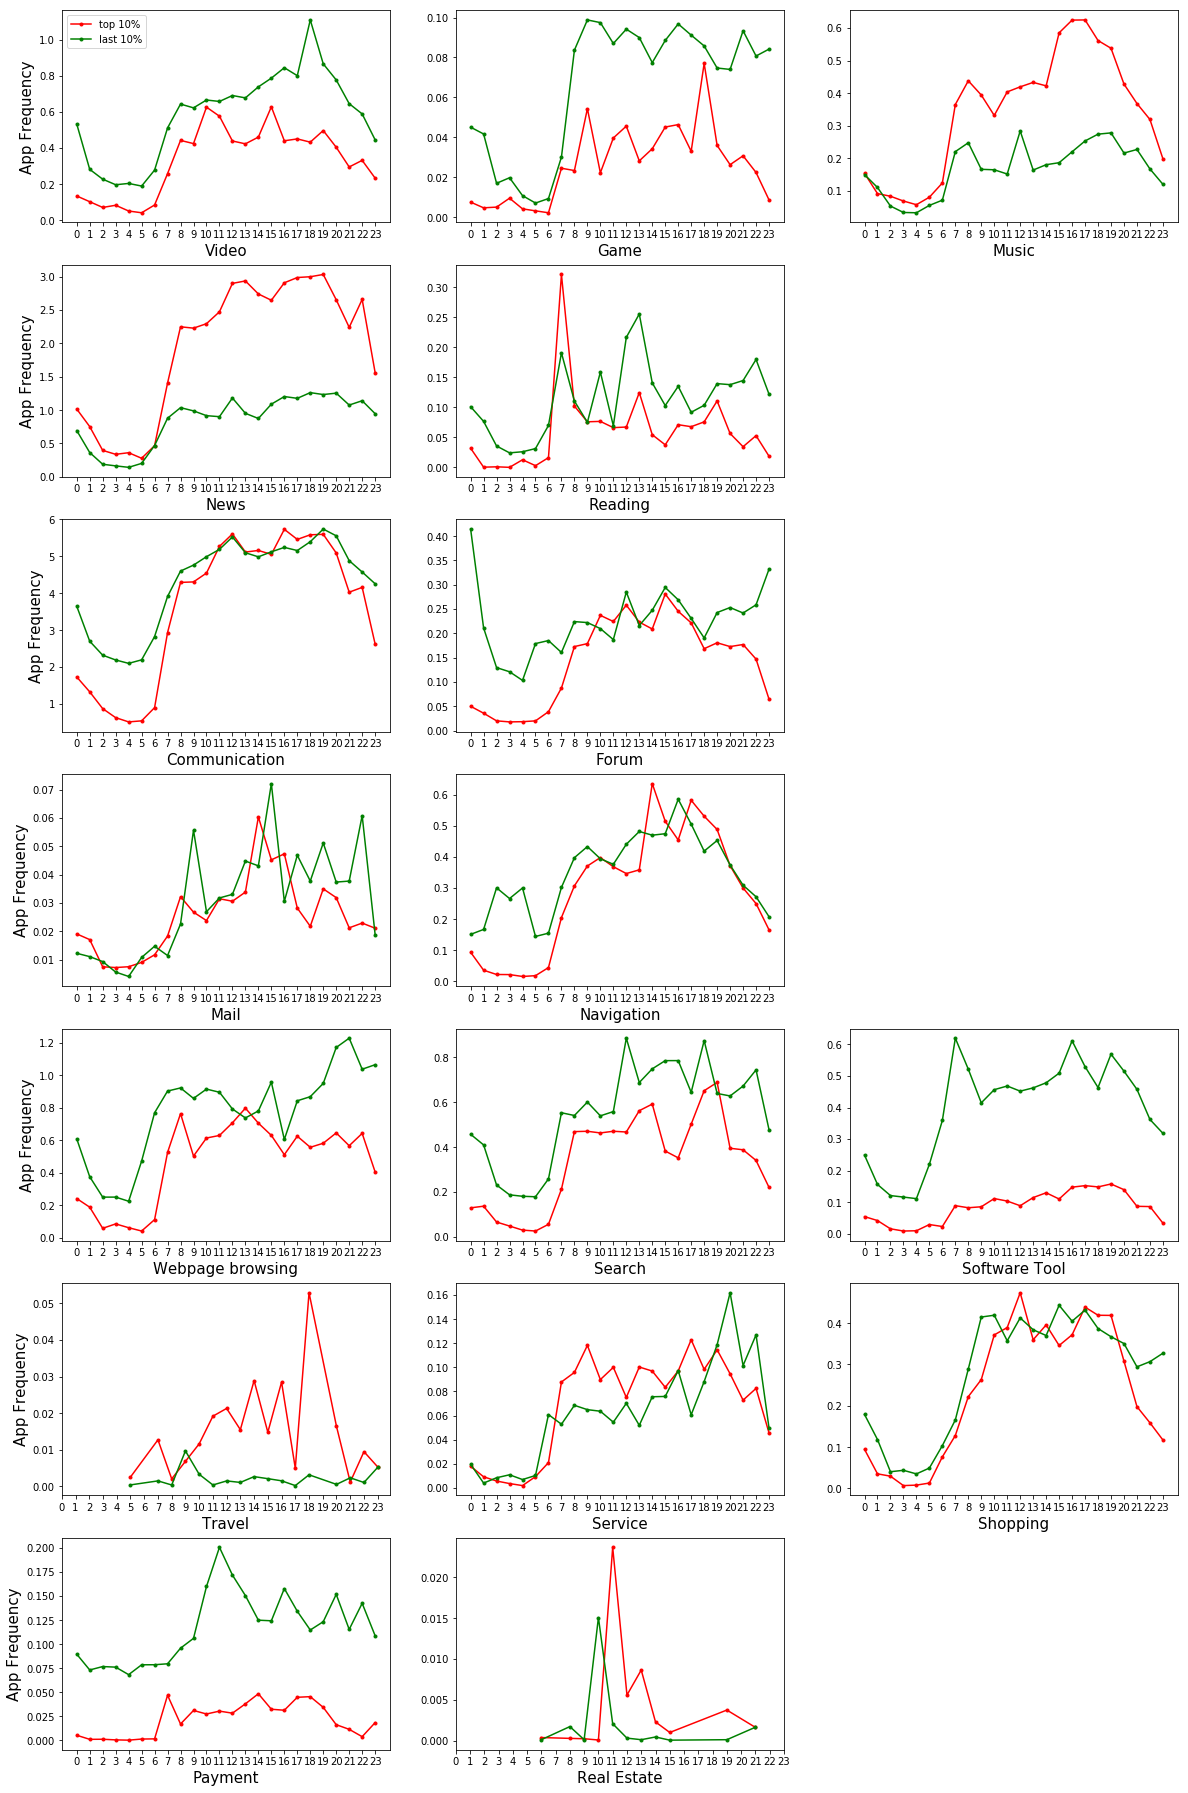

In [17]:
plt.show()

# location

In [9]:
node=pd.read_csv('./node.csv',names=['user_id','longtitude','latitude','app_name','app_type_name','start_time'],index_col=0)
node=node[['user_id','latitude','longtitude','start_time']]
node['location']=node['latitude'].astype('str')+','+node['longtitude'].astype('str')
node=node[['user_id','location','start_time']]
node=node.drop_duplicates()

node['date']=node['start_time'].apply(lambda x: int(str(x)[6:8]))
node['hour']=node['start_time'].apply(lambda x: int(str(x)[8:10]))

node=node[['user_id','location','date','hour']]
node=node.drop_duplicates()

node = node[node['location'].astype('str') != 'nan,nan'] 

In [11]:
# choose the top 10% and last 10%
zscore_category=pd.read_csv('./siteexample1/zscore_category.csv',index_col=0)

lowest=zscore_category.sort_values(by=['terminal_price','fees'],ascending=False)[int(len(zscore_category)*0.90):-1]
lower_class=lowest['user_id'].values

highest=zscore_category.sort_values(by=['terminal_price','fees'],ascending=False)[:int(len(zscore_category)*0.10)-1]
upper_class=highest['user_id'].values

In [12]:
low=node.loc[node['user_id'].isin(lower_class)]
# low=node.loc[~node['user_id'].isin(lower_class)] isnotin

low_date_count=low.groupby('user_id')['date'].nunique().reset_index()

low_overall=low.groupby(['user_id'])['hour'].value_counts().reset_index(name='count')

diction=dict(low_date_count[['user_id','date']].values)

low_overall['date']=low_overall['user_id'].apply(lambda x : diction[x]
                                                if x in diction
                                                else np.nan)

low_overall['low_number']=low_overall['count']/low_overall['date']

low_overall=low_overall.groupby('hour')['low_number'].sum().reset_index()
low_overall['low_number']=low_overall['low_number']/len(lower_class)

In [14]:
high=node.loc[node['user_id'].isin(upper_class)]

high_date_count=high.groupby('user_id')['date'].nunique().reset_index()

high_overall=high.groupby(['user_id'])['hour'].value_counts().reset_index(name='count')

diction=dict(high_date_count[['user_id','date']].values)

high_overall['date']=high_overall['user_id'].apply(lambda x : diction[x]
                                                if x in diction
                                                else np.nan)

high_overall['high_number']=high_overall['count']/high_overall['date']

high_overall=high_overall.groupby('hour')['high_number'].sum().reset_index()
high_overall['high_number']=high_overall['high_number']/len(upper_class)

In [15]:
mobility=pd.merge(high_overall,low_overall,on='hour')

In [16]:
mobility

,hour,high_number,low_number
0,0,0.144875,0.271652
1,1,0.093346,0.231832
2,2,0.072687,0.191663
3,3,0.051441,0.186941
4,4,0.050373,0.179095
5,5,0.055328,0.196926
6,6,0.100329,0.273739
7,7,0.248976,0.509004
8,8,0.375880,0.597079
9,9,0.430086,0.586621


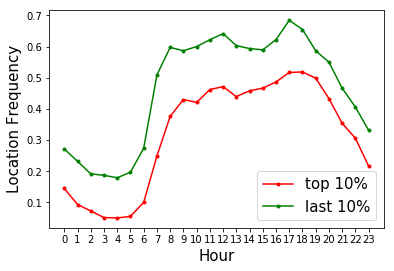

In [17]:
x=range(0,24)
plt.plot(x,mobility['high_number'].values,'.-',label='top 10%',color='red')
plt.plot(x,mobility['low_number'].values,'.-',label='last 10%',color='green')
plt.legend(fontsize=15)
plt.xticks(x,)
plt.xlabel('Hour',fontsize=15)
plt.ylabel('Location Frequency',fontsize=15)
plt.show()

In [11]:
# example of every category

app_type_name=['位置', '其他资讯', '社交沟通', '网页浏览', '视频', '软件工具', '搜索', '旅游',
       '生活服务', '社区论坛', '邮箱', '游戏', '阅读', '音乐', '支付', '电商购物', '房产',
       '招聘']

node=pd.read_csv('./node.csv',names=['user_id','longtitude','latitude','app_name','app_type_name','start_time'],index_col=0)
node=node[['user_id','app_name','app_type_name']]

for i in app_type_name:
    print(i)
    print(node[node['app_type_name']==i]['app_name'].unique())

位置
['百度地图' '谷歌地图' '移动手机导航' '导航犬' '高德导航' '迷你地图' '搜搜地图' '小米司机' '图吧地图' '老虎宝典'
 '悠悠导航' '搜狗地图' '丁丁生活' '高德地图']
其他资讯
['手机腾讯网' '百度新闻' '同花顺炒股' '移动手机证券大智慧版' '掌中新浪' '搜狐新闻' '新浪新闻' '今日头条' '证券之星'
 '凤凰新闻' '大智慧炒股' 'BBC新闻' '网易新闻' '体坛周报' '益盟操盘手' '饭否' '手机证券' '纽约时报']
社交沟通
['QQ' '微信' '新浪微博' 'YY语音' '米聊' '阿里旺旺' '陌陌' '爱聊' '来往' '佳缘' '搜狐微博' '飞信' '瓦力短信'
 '易信' '腾讯微博' 'GO短信' '飞聊' 'MSN' '雅虎通' '微软Skype' '新浪UC语音']
网页浏览
['QQ浏览器' '360安全浏览器' 'UC浏览器' 'SAFARI浏览器' '火狐浏览器' '百度浏览器' '欧朋浏览器' '遨游浏览器'
 '海豚浏览器']
视频
['QQLive' '优酷视频' '奇艺高清影视' 'QVOD快播' 'PPS影音' '乐视视频' '迅雷看看' '暴风影音' '移动手机视频'
 '新浪视频' '风行影视' '快手' '土豆视频' '时光网' 'PPTV网络电视' '凤凰视频' '移动手机动漫' 'UUSee网络电视']
软件工具
['熊猫桌面' '91助手' '360安全卫士' '豌豆荚' '灵犀' '360手机助手' '百度输入法' '美图秀秀' '搜狗输入法' '手雷'
 '有道词典' '应用汇' '金山词霸' '来电通' 'POCO美人相机' '无线城市' '随e行' 'QQ输入法' '彩票365' '通通电话'
 '号簿管家' '彩云' '省电任务管理器' '电驴大全' '挖财记账理财']
搜索
['掌上百度']
旅游
['去哪儿旅行' '携程无线' '中国国航' '艺龙无线' '航班管家' '航旅纵横' '东方航空' '海南航空' '酷讯移动' '超级火车票'
 '路路通时刻表' '南方航空' '盛名列车时刻' '神州租车']
生活服务
['墨迹天气' '91黄历天气' '雅虎天气' '移动掌上营业厅' '天气通' '8684公交查询' '我查查' '